In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Uplift analysis and attribution estimation
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.proportion import proportion_confint

import os
import warnings 
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_excel('marketing_AB.xlsx')
data.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [68]:
def summarize_dataframe(df):
    """
    Summarizes a pandas DataFrame with both general information and detailed column-level stats.

    Parameters:
        df (pd.DataFrame): The DataFrame to summarize.

    Returns:
        pd.DataFrame: A summary table with per-column metadata including type, nulls, stats, and frequency.
    """

    # 1. Print high-level structure of the DataFrame
    print("BASIC DATAFRAME INFO")
    print(f"- Number of rows: {df.shape[0]}")
    print(f"- Number of columns: {df.shape[1]}")
    print(f"- Column names: {list(df.columns)}")
    print("\n- Column data types:\n", df.dtypes)
    print(f"\n- Total missing values: {df.isnull().sum().sum()}")
    print(f"- Duplicate rows: {df.duplicated().sum()}")
    print("-" * 50)
    
    # 2. Initialize a list to store column-wise summaries
    summary = []

    # 3. Iterate over each column to collect type-specific stats
    for col in df.columns:
        col_data = df[col]  # current column data
        col_type = col_data.dtype  # column dtype

        # If numeric column
        if pd.api.types.is_numeric_dtype(col_data):
            summary.append({
                'Column': col,
                'Type': 'Numeric',
                'Non-Null Count': col_data.notnull().sum(),
                'Missing Values': col_data.isnull().sum(),
                'Mean': col_data.mean(),
                'Std Dev': col_data.std(),
                'Min': col_data.min(),
                'Max': col_data.max(),
                'Unique Values': col_data.nunique()
            })

        # If categorical or string column
        elif pd.api.types.is_categorical_dtype(col_data) or pd.api.types.is_object_dtype(col_data):
            summary.append({
                'Column': col,
                'Type': 'Categorical',
                'Non-Null Count': col_data.notnull().sum(),
                'Missing Values': col_data.isnull().sum(),
                'Most Frequent': col_data.mode().iloc[0] if not col_data.mode().empty else None,
                'Frequency': col_data.value_counts().iloc[0] if not col_data.value_counts().empty else None,
                'Unique Values': col_data.nunique()
            })
            print(f"column : {col}",df[col].unique(),"\n")

        # If datetime column
        elif pd.api.types.is_datetime64_any_dtype(col_data):
            summary.append({
                'Column': col,
                'Type': 'Datetime',
                'Non-Null Count': col_data.notnull().sum(),
                'Missing Values': col_data.isnull().sum(),
                'Min': col_data.min(),
                'Max': col_data.max(),
                'Unique Values': col_data.nunique()
            })

        # Fallback for any other column type
        else:
            summary.append({
                'Column': col,
                'Type': 'Other',
                'Non-Null Count': col_data.notnull().sum(),
                'Missing Values': col_data.isnull().sum(),
                'Unique Values': col_data.nunique()
            })

    # 4. Convert collected summaries into a new DataFrame
    summary_df = pd.DataFrame(summary)

    # 5. Return the summary table
    print("COLUMN-WISE SUMMARY")
    return summary_df

In [70]:
summarize_dataframe(data)

BASIC DATAFRAME INFO
- Number of rows: 588101
- Number of columns: 5
- Column names: ['test group', 'converted', 'total ads', 'most ads day', 'most ads hour']

- Column data types:
 test group       object
converted          bool
total ads         int64
most ads day     object
most ads hour     int64
dtype: object

- Total missing values: 0
- Duplicate rows: 543623
--------------------------------------------------
column : test group ['ad' 'psa'] 

column : most ads day ['Monday' 'Tuesday' 'Friday' 'Saturday' 'Wednesday' 'Sunday' 'Thursday'] 

COLUMN-WISE SUMMARY


,Column,Type,Non-Null Count,Missing Values,Most Frequent,Frequency,Unique Values,Mean,Std Dev,Min,Max
0,test group,Categorical,588101,0,ad,564577.0,2,NaN,NaN,NaN,NaN
1,converted,Numeric,588101,0,NaN,NaN,2,0.025239,0.156850,False,True
2,total ads,Numeric,588101,0,NaN,NaN,807,24.820876,43.715181,1,2065
3,most ads day,Categorical,588101,0,Friday,92608.0,7,NaN,NaN,NaN,NaN
4,most ads hour,Numeric,588101,0,NaN,NaN,24,14.469061,4.834634,0,23


In [40]:
#drop extra columns from the dataset
data.drop(columns = ['Unnamed: 0','user id'],inplace = True)
data.head()

,test group,converted,total ads,most ads day,most ads hour
0,ad,False,130,Monday,20
1,ad,False,93,Tuesday,22
2,ad,False,21,Tuesday,18
3,ad,False,355,Tuesday,10
4,ad,False,276,Friday,14


In [48]:
data['converted'].value_counts(normalize = True)

converted
False    0.974761
True     0.025239
Name: proportion, dtype: float64

In [52]:
data['test group'].value_counts(normalize = True)

test group
ad     0.96
psa    0.04
Name: proportion, dtype: float64

In [66]:
table = pd.crosstab(data['test group'], data['converted'],margins=True, normalize='index')
table

converted,False,True
test group,,
ad,0.974453,0.025547
psa,0.982146,0.017854
All,0.974761,0.025239


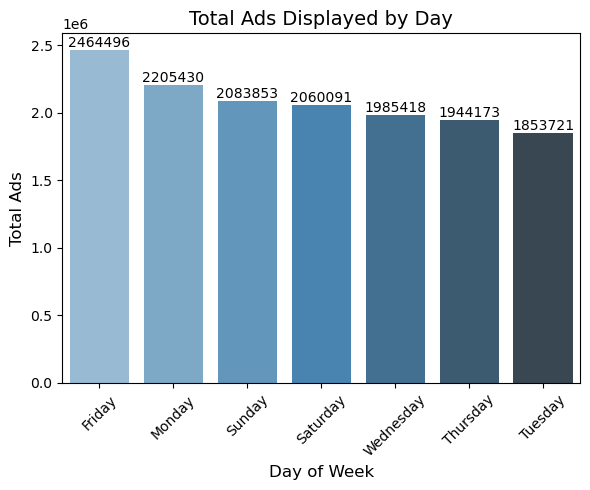

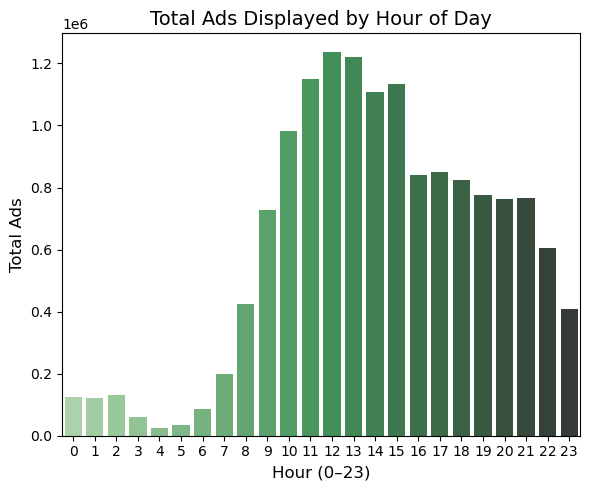

In [95]:
ads_by_day = data.groupby('most ads day')['total ads'].sum().sort_values(ascending=False)

# 📍 3️⃣ Plot: Ads Distribution by Day
plt.figure(figsize=(6, 5))
sns.barplot(x=ads_by_day.index, y=ads_by_day.values, palette='Blues_d')

# 🔠 Add labels above bars
for i, val in enumerate(ads_by_day.values):
    plt.text(i, val + 5, f"{val}", ha='center', va='bottom', fontsize=10)

# 🖼 Chart Labels
plt.title('Total Ads Displayed by Day', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Total Ads', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 📊 4️⃣ Group by Hour and Sum 'total ads'
ads_by_hour = data.groupby('most ads hour')['total ads'].sum().sort_index()

# 📍 5️⃣ Plot: Ads Distribution by Hour
plt.figure(figsize=(6, 5))
sns.barplot(x=ads_by_hour.index, y=ads_by_hour.values, palette='Greens_d')

# 🖼 Chart Labels
plt.title('Total Ads Displayed by Hour of Day', fontsize=14)
plt.xlabel('Hour (0–23)', fontsize=12)
plt.ylabel('Total Ads', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

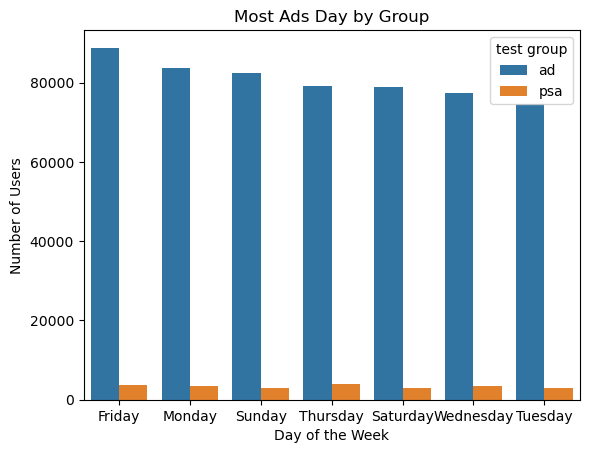

In [89]:
# Count of most ads day in descending order by total ads
most_ads_day_order = data['most ads day'].value_counts().sort_values(ascending=False).index
sns.countplot(data=data, x='most ads day', hue='test group', order=most_ads_day_order)
plt.title("Most Ads Day by Group")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Users")
plt.show()

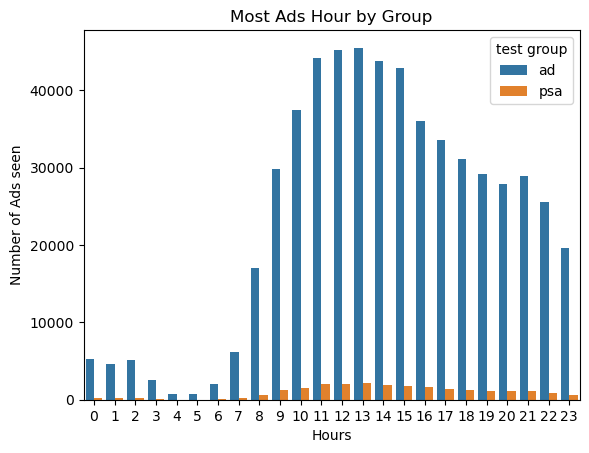

In [91]:
# Count of most ads hour
sns.countplot(data=data, x='most ads hour', hue='test group')
plt.title("Most Ads Hour by Group")
plt.ylabel("Number of Ads seen")
plt.xlabel("Hours")
plt.show()

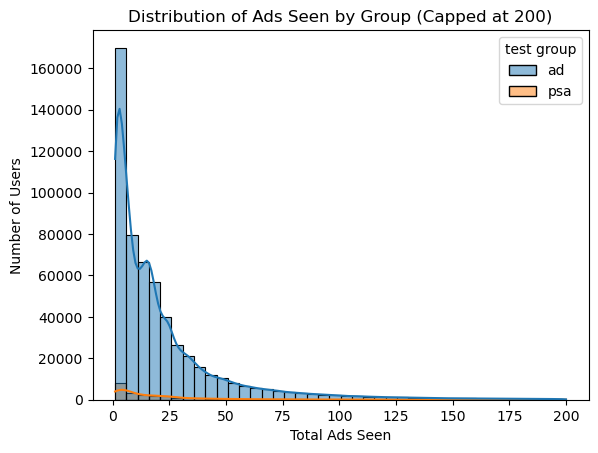

In [99]:
# Filter to users who saw <= 200 ads
filtered_df = data[data['total ads'] <= 200]

# Plot filtered histogram by group
sns.histplot(data=filtered_df, x='total ads', hue='test group', kde=True, bins=40)
plt.title("Distribution of Ads Seen by Group (Capped at 200)")
plt.xlabel("Total Ads Seen") 
plt.ylabel("Number of Users")
plt.show()

In [103]:
ads = data[data['test group']== 'ad']
psa = data[data['test group']== 'psa']
ads.shape,psa.shape

((564577, 5), (23524, 5))

In [147]:
psa['total ads'].min(),psa['total ads'].max()

(1, 907)

In [161]:
def create_bins(df):
    if df['total ads'].max()>1000:
        bins = [0,10,20,50,100,200,1000,df['total ads'].max()]
        labels = ['0-10','11-20','21-50','51-100','101-200','200-1000','>1000']
    else:
        bins = [0,10,20,50,100,200,df['total ads'].max()]
        labels = ['0-10','11-20','21-50','51-100','101-200','200-1000']
    df['ad_bins'] = pd.cut(df['total ads'],bins = bins, labels = labels, include_lowest = True)
    return df

In [163]:
create_bins(ads)

,test group,converted,total ads,most ads day,most ads hour,ad_bins
0,ad,False,130,Monday,20,101-200
1,ad,False,93,Tuesday,22,51-100
2,ad,False,21,Tuesday,18,21-50
3,ad,False,355,Tuesday,10,200-1000
4,ad,False,276,Friday,14,200-1000
...,...,...,...,...,...,...
588096,ad,False,1,Tuesday,23,0-10
588097,ad,False,1,Tuesday,23,0-10
588098,ad,False,3,Tuesday,23,0-10
588099,ad,False,1,Tuesday,23,0-10


In [165]:
create_bins(psa)

,test group,converted,total ads,most ads day,most ads hour,ad_bins
18,psa,False,248,Saturday,19,200-1000
38,psa,False,27,Thursday,8,21-50
68,psa,False,13,Tuesday,19,11-20
140,psa,False,32,Wednesday,19,21-50
157,psa,False,105,Tuesday,19,101-200
...,...,...,...,...,...,...
588052,psa,False,16,Tuesday,22,11-20
588063,psa,False,3,Tuesday,22,0-10
588066,psa,False,1,Tuesday,22,0-10
588069,psa,False,6,Tuesday,22,0-10


In [167]:
ads['converted'] = ads['converted'].astype(int)
psa['converted'] = psa['converted'].astype(int)

In [196]:
def conversion_by_bins(df):
    # Compute conversion rate per bin
    conversion_by_ads_bin = df.groupby('ad_bins')['converted'].mean().reset_index()

    # Bar plot of conversion rate by total ads seen bin
    ax = sns.barplot(data=conversion_by_ads_bin, x='ad_bins', y='converted')
    plt.title(f"Conversion Rate by {df['test group'].unique()[0]}")
    plt.ylabel("Conversion Rate")
    plt.xlabel("Ads Seen Bin")

    # Add value labels to bars
    for i, row in conversion_by_ads_bin.iterrows():
        ax.text(i, row['converted'] + 0.0005, f"{row['converted']:.1%}", ha='center')

    plt.show()

    #Display conversion rates
    print(conversion_by_ads_bin)

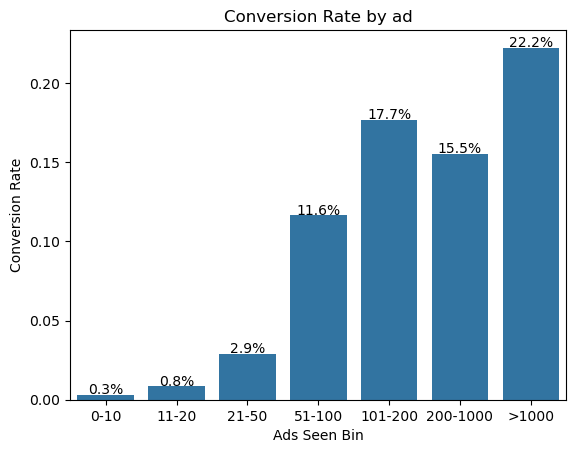

    ad_bins  converted
0      0-10   0.003259
1     11-20   0.008400
2     21-50   0.029154
3    51-100   0.116311
4   101-200   0.176773
5  200-1000   0.155355
6     >1000   0.222222


In [198]:
conversion_by_bins(ads)

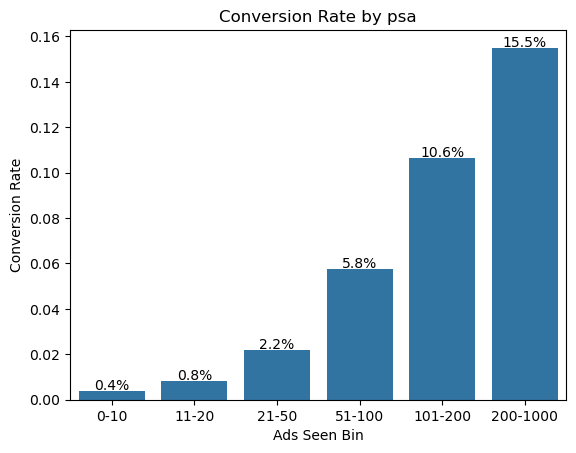

    ad_bins  converted
0      0-10   0.003991
1     11-20   0.008193
2     21-50   0.021777
3    51-100   0.057744
4   101-200   0.106383
5  200-1000   0.155039


In [200]:
conversion_by_bins(psa)

In [202]:
ads.head()

,test group,converted,total ads,most ads day,most ads hour,ad_bins
0,ad,0,130,Monday,20,101-200
1,ad,0,93,Tuesday,22,51-100
2,ad,0,21,Tuesday,18,21-50
3,ad,0,355,Tuesday,10,200-1000
4,ad,0,276,Friday,14,200-1000


In [208]:
# Calculate correlations
ad_corr = ads[['total ads', 'converted']].corr().loc['total ads', 'converted']
psa_corr = psa[['total ads','converted']].corr().loc['total ads','converted']
print(round(ad_corr,3),round(psa_corr,3))

0.219 0.184


In [210]:
table

converted,False,True
test group,,
ad,0.974453,0.025547
psa,0.982146,0.017854
All,0.974761,0.025239


In [220]:
# Grab value for 'ad' group under column True
ad_true = table.loc['ad', True]

# Grab value for 'psa' group under column True
psa_true = table.loc['psa', True]

uplift = ad_true - psa_true

print("Ad - conversion%:", round(100.0*ad_true,3))
print("PSA - conversion%:", round(100.0*psa_true,3))
print("Uplift%:", round(100.0*uplift,3))

Ad - conversion%: 2.555
PSA - conversion%: 1.785
Uplift%: 0.769


In [222]:
# Count conversions and totals for both groups
ad_converted = data[data['test group'] == 'ad']['converted'].sum()
ad_total = data[data['test group'] == 'ad'].shape[0]

psa_converted = data[data['test group'] == 'psa']['converted'].sum()
psa_total = data[data['test group'] == 'psa'].shape[0]

In [228]:
# Z-test for proportions
ad_count = [ad_converted, psa_converted]
ad_nobs = [ad_total, psa_total]
print(f'ads converted:{ad_count}')
print(f'total ads:{ad_nobs}')

ads converted:[14423, 420]
total ads:[564577, 23524]


In [230]:
z_stat, p_value = proportions_ztest(ad_count, ad_nobs, alternative='larger')

print(f"Z-statistic: {z_stat:.5f}")
print(f"P-value: {p_value:.5f}")

Z-statistic: 7.37008
P-value: 0.00000


The p-value is far below 0.05, so we reject the null hypothesis. There is strong statistical evidence that the ad_group had a higher conversion rate than the PSA group. Therefore, the uplift is real and statistically significant.

In [233]:
# Attribution & Incremental Conversions
# (0.77% * 564577)
incremental_conversions = uplift * ad_total 
print(f"Estimated Incremental Conversions from Ads: {int(incremental_conversions)}")

Estimated Incremental Conversions from Ads: 4342


In [241]:
# Revenue per conversion (assume)
avg_revenue_per_conversion = 50  # adjust as needed
incremental_revenue = incremental_conversions * avg_revenue_per_conversion
print(f"Estimated Incremental Revenue: ${incremental_revenue:,.2f}")

Estimated Incremental Revenue: $217,149.11


In [243]:
# Summary printout for uplift and statistical significance
avg_revenue_per_conversion = 50
print("\n--- Uplift Summary ---")
print(f"Ad Group Conversion Rate: {ad_true:.2%}")
print(f"PSA Group Conversion Rate: {psa_true:.2%}")
print(f"Absolute Uplift: {uplift:.2%}")
print(f"Z-Statistic: {z_stat:.2f}")
print(f"P-Value: {p_value:.4f}")
print(f"Statistically Significant: {'Yes' if p_value < 0.05 else 'No'}")
print(f"Incremental Conversions: {int(incremental_conversions)}")
print(f"Estimated Incremental Revenue (at ${avg_revenue_per_conversion} per conversion): ${incremental_revenue:,.2f}")


--- Uplift Summary ---
Ad Group Conversion Rate: 2.55%
PSA Group Conversion Rate: 1.79%
Absolute Uplift: 0.77%
Z-Statistic: 7.37
P-Value: 0.0000
Statistically Significant: Yes
Incremental Conversions: 4342
Estimated Incremental Revenue (at $50 per conversion): $217,149.11
